# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [23]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval, verbose = True):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()

    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    
    epoch_loss = 0
    for idx, (data, gt) in enumerate(train_loader):
        
        if use_cuda:
            data, gt = data.cuda(), gt.cuda()

        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        pred = model(data)
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(pred, gt)
        
        # TODO: do backpropagation
        loss.backward()
        epoch_loss += loss.item()

        # TODO: optimize
        optimizer.step()

        # TODO: print current loss for every nth ("log_interval"th) iteration
        if verbose:
            if idx % log_interval == 0: 
                    print(f'Train Epoch: {epoch} [{idx * len(data)}/{len(train_loader.dataset)} '
                    f'({100. * idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    return epoch_loss / len(train_loader.dataset)  
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [7]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 100),
            nn.Sigmoid(),
            nn.Linear(100, 60),
            nn.Sigmoid(),
            nn.Linear(60, 30),
            nn.Sigmoid(),
            nn.Linear(30, 10)
        )
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run network layers
        output = self.fc_layers(x)        
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(output, dim=1)
        
        return output

In [8]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 10)
        )

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run network layers
        output = self.fc_layers(x)        
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(output, dim=1)
        
        return output

In [9]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.BatchNorm1d(60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 10)
        )

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run network layers
        output = self.fc_layers(x)        
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(output, dim=1)
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [34]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU()
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.cnn_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = self.fc_layers(x) 
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [40]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        # TODO: initialize network layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU()
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.cnn_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = self.fc_layers(x) 
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [41]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        # TODO: initialize network layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.cnn_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = self.fc_layers(x) 
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299157
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.403246
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.213164
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.116218
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.331402
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.208155
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.093446
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.139158
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.260306
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.020237

Test set: Average loss: 0.1190, Accuracy: 9632/10000 (96.32%)



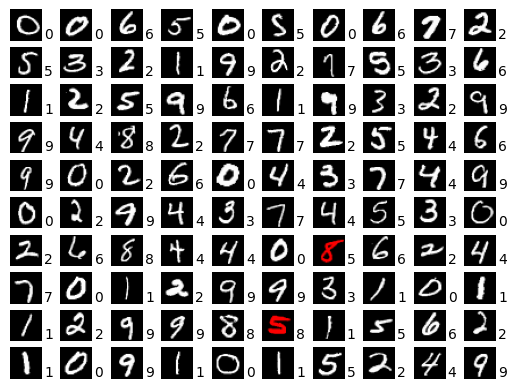

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.046864
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.016221
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.029083
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.137210
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.053740
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.066759
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.090908
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.019882
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.052857
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.013522

Test set: Average loss: 0.1014, Accuracy: 9703/10000 (97.03%)



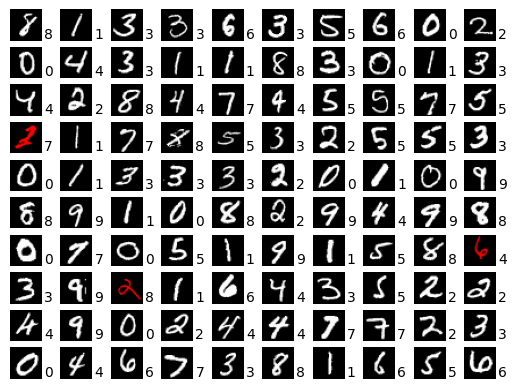

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.007247
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.022482
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.008138
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.138564
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.134140
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.008105
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.037662
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.148893
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.004036
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.216061

Test set: Average loss: 0.0856, Accuracy: 9771/10000 (97.71%)



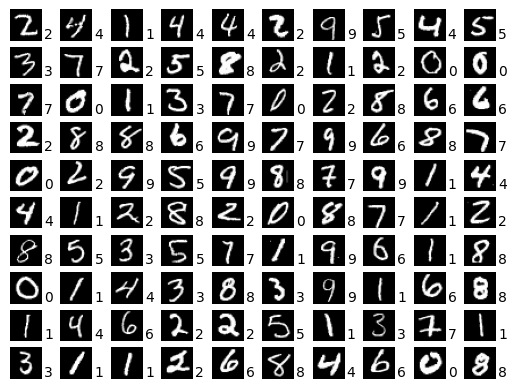

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.158685
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.051489
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.020112
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.029147
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.003843
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.008363
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.016106
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.025598
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.003515
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.065228

Test set: Average loss: 0.0759, Accuracy: 9804/10000 (98.04%)



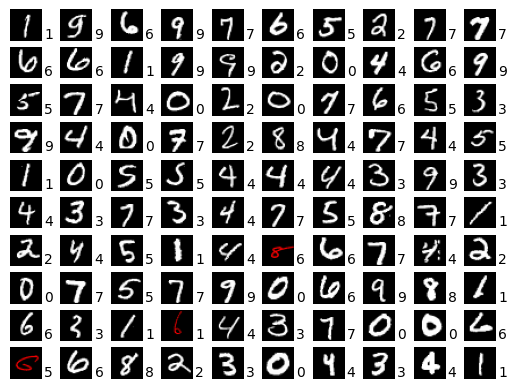

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.003897
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000442
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.034521
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.001506
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.156546
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000524
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000271
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.006859
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000521
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.001683

Test set: Average loss: 0.0765, Accuracy: 9823/10000 (98.23%)



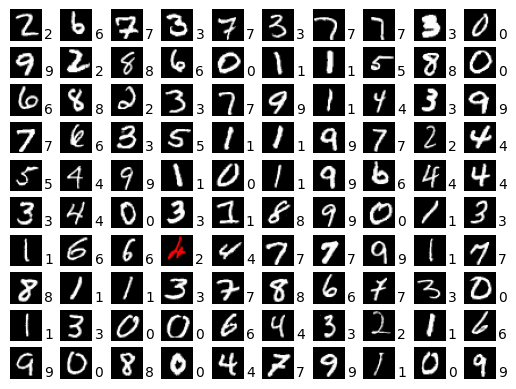

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.056898
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.013387
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.025328
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.065831
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.006908
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.011546
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.018422
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.003125
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.006504
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.015060

Test set: Average loss: 0.0827, Accuracy: 9822/10000 (98.22%)



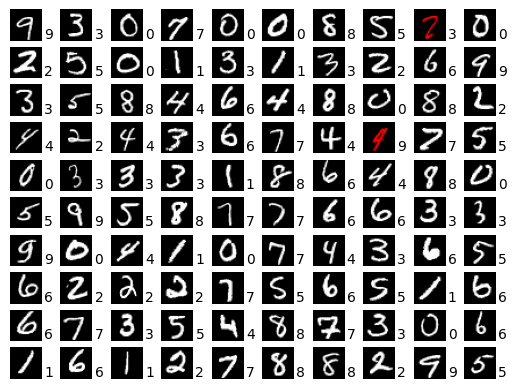

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.003440
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000664
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.001431
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000705
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.026233
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.004308
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000337
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.001387
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000504
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.055007

Test set: Average loss: 0.0868, Accuracy: 9802/10000 (98.02%)



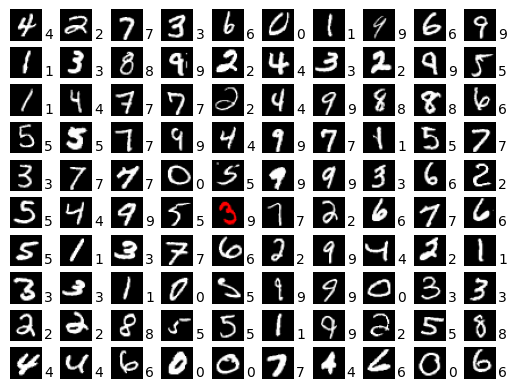

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.002276
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.005993
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000035
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000490
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000217
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000945
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.172064
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000585
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.004137
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000064

Test set: Average loss: 0.0883, Accuracy: 9810/10000 (98.10%)



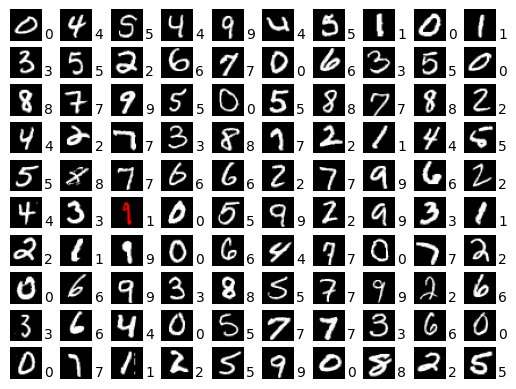

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.003576
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000790
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001802
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.005973
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.002416
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.004573
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.058986
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000096
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000711
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000085

Test set: Average loss: 0.0909, Accuracy: 9812/10000 (98.12%)



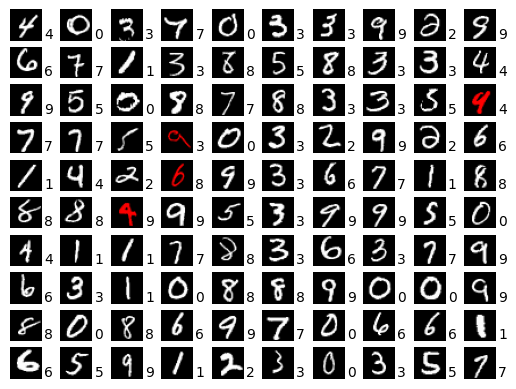

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.001429
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.001403
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.001242
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000358
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000089
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000091
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000935
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000418
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000620
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000565

Test set: Average loss: 0.0927, Accuracy: 9814/10000 (98.14%)



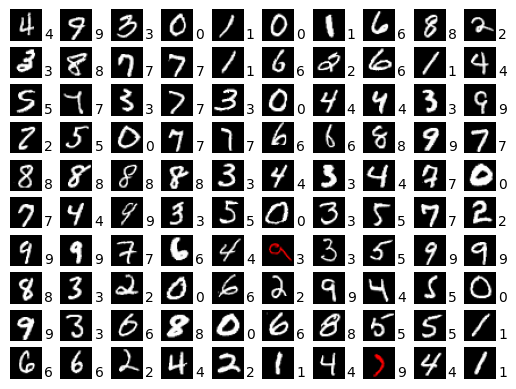

In [21]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    _ = train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

In [45]:
models = {
    'FCNet1': FCNet1,
    'FCNet2': FCNet2,
    'FCNet3': FCNet3,
    'ConvNet1': ConvNet1,
    'ConvNet2': ConvNet2,
    'ConvNet3': ConvNet3
}

losses = {}

for model_name, model_class in models.items():
    print(f"Training {model_name}...")
    model = model_class()
    if use_cuda:
        model = model.cuda()

    losses[model_name] = []

    # initialize optimizer and scheduler
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        # train one epoch
        loss = train(model, use_cuda, train_loader, optimizer, epoch, log_interval, verbose=False)
        losses[model_name].append(loss)

Training FCNet1...
Training FCNet2...
Training FCNet3...
Training ConvNet1...
Training ConvNet2...
Training ConvNet3...


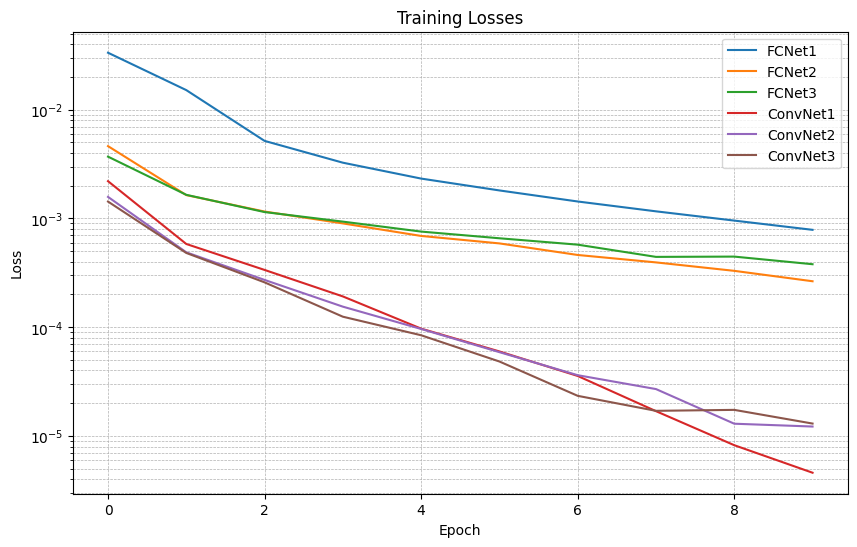

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
for model_name, model_losses in losses.items():
    ax.plot(model_losses, label=model_name)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_title('Training Losses')
ax.legend()